### メモ
Data Augmentation を実行
チューニングはなし

### Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.datasets import cifar10
from keras.models import Model
from keras.preprocessing .image import ImageDataGenerator
from keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import datetime
import optuna
from sklearn.model_selection import KFold
from optuna.samplers import TPESampler, GridSampler
from sklearn.manifold import TSNE
from keras.callbacks import TensorBoard
from tqdm import tqdm

2023-12-21 14:31:52.457150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 14:31:52.457175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 14:31:52.457907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 14:31:52.462993: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 14:31:53.248599: W tensorflow/compiler/tf2

### Data

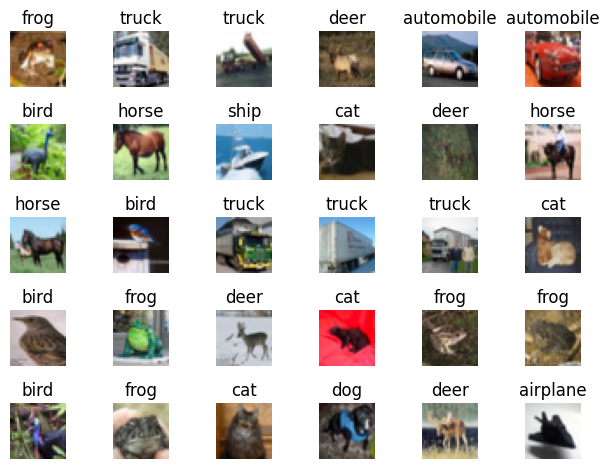

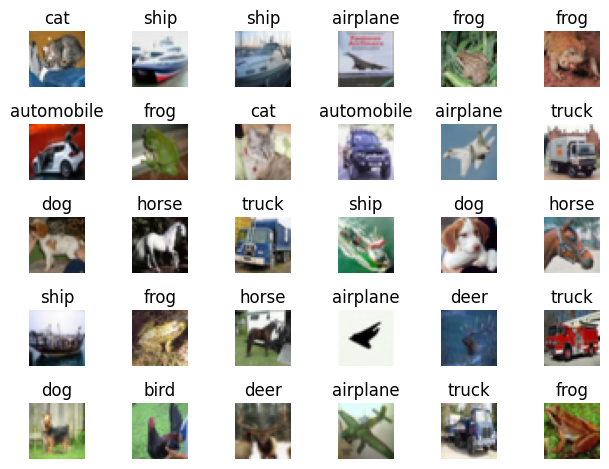

num_class: 10


In [2]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#ラベルの設定
labels = np.array([
    'airplane',  #飛行機
    'automobile',#バイク
    'bird',      #鳥
    'cat',       #猫
    'deer',      #鹿
    'dog',       #犬
    'frog',      #カエル
    'horse',     #馬
    'ship',      #船
    'truck'      #トラック
    ])

#画像の表示のための関数
def image_show(x, y, labels):
    for i in range(30):
        plt.subplot(5, 6, i+1)
        #軸を表示しない
        plt.axis("off")
        #タイトルをラベルの名前で表示
        plt.title(labels[y[i][0]])
        #表示
        plt.imshow(x[i])
    plt.tight_layout()
    plt.show()
    return    

# トレーニングデータの画像とラベルをセットで表示してみる
image_show(X_train, y_train, labels)
image_show(X_test, y_test, labels)

# 正解ラベルの中身の種類 (0~9)をlistに格納
class_list = np.unique(y_train).tolist()
num_class = len(class_list)
print("num_class:", num_class)

# データの前処理
# ラベルをバイナリクラスにする(yの値を10この数値の配列に変換している)
categorical_y_train = to_categorical(y_train, num_class)
categorical_y_test = to_categorical(y_test, num_class)

### CNN

In [30]:
inputs = Input(shape=X_train[0].shape)
x = Conv2D(64, (3,3), padding = "same", activation="relu")(inputs)

for i in range(5):
    x = Conv2D(64*2**(i-1), (3,3), padding="same", activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2,2), padding="same")(x)
    x = Dropout(0.2)(x)

intermediate_layer = Conv2D(32, (3,3), padding="same", activation="relu")(x)

# 平滑化
x = Flatten()(intermediate_layer)

# 全統合
x = Dense(512, activation="relu")(x)
x = Dropout(0.6)(x)
predictions = Dense(num_class, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"]
)

### Log

In [31]:
keras.utils.plot_model(model, to_file="/home/gakubu/デスクトップ/ML_git/MLT/ML_11/model.png", 
                        show_shapes=True, show_layer_activations="True")

# tensorboard を使用
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

### Data Augmentation

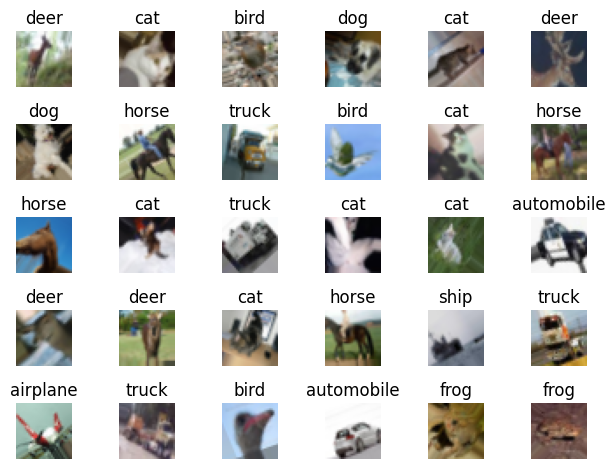

In [32]:
# ImageDataGeneratorクラスの作成
augmentation_train_datagen = ImageDataGenerator(
    rotation_range=45,          # 回転
    horizontal_flip=True,       # 左右反転
    height_shift_range=0.1,     # 上下平行移動
    width_shift_range=0.1,      # 左右平行移動
    zoom_range=0.1,             # ランダムにズーム
    channel_shift_range = 0.2,  # チャンネルシフト
    rescale=1./255              # スケーリング
)

# データ拡張を適用
train_generator = augmentation_train_datagen.flow(X_train, categorical_y_train,batch_size=256)

X_gen, y_gen = train_generator.next()
y_gen = np.argmax(y_gen, axis=1)
y_gen_labels = y_gen.reshape(-1, 1)
for i in range(30): 
    plt.subplot(5, 6, i+1)
    plt.imshow(X_gen[i])
    plt.axis("off")
    titles = labels[y_gen_labels[i][0]]
    plt.title(titles)
plt.tight_layout()
plt.show()

### Learn

Epoch 1/10
196/196 [==============================] - 97s 492ms/step - loss: 1.1844 - accuracy: 0.5805 - val_loss: 227.4197 - val_accuracy: 0.2334
Epoch 2/10
196/196 [==============================] - 108s 550ms/step - loss: 1.1168 - accuracy: 0.6091 - val_loss: 308.2644 - val_accuracy: 0.1823
Epoch 3/10
196/196 [==============================] - 106s 542ms/step - loss: 1.0503 - accuracy: 0.6343 - val_loss: 240.2163 - val_accuracy: 0.1898
Epoch 4/10
196/196 [==============================] - 108s 549ms/step - loss: 0.9986 - accuracy: 0.6546 - val_loss: 192.2432 - val_accuracy: 0.2918
Epoch 5/10
196/196 [==============================] - 106s 542ms/step - loss: 0.9670 - accuracy: 0.6635 - val_loss: 231.3994 - val_accuracy: 0.2319
Epoch 6/10
196/196 [==============================] - 106s 541ms/step - loss: 0.9353 - accuracy: 0.6747 - val_loss: 151.1925 - val_accuracy: 0.2864
Epoch 7/10
196/196 [==============================] - 108s 553ms/step - loss: 0.9085 - accuracy: 0.6899 - val_los

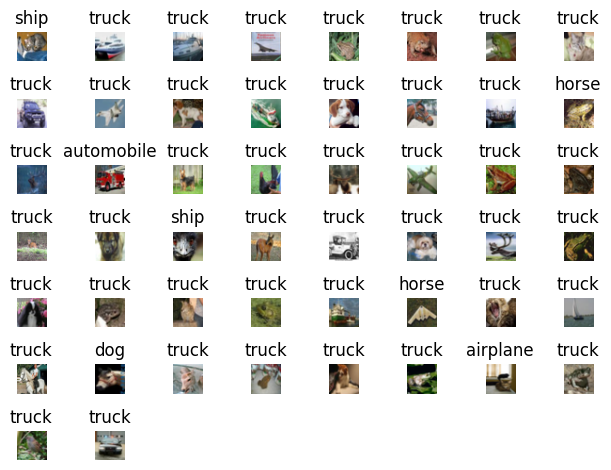

num_correct: 2713
num_valid_samples: 10000
accuracy: 0.2713


In [39]:
model.fit(train_generator,
        epochs=10,
        verbose=1,
        validation_data=(X_test, categorical_y_test),
        callbacks=[tensorboard_callback, EarlyStopping(patience=10)]
)

# テストデータに対する予測
y_test_pred = model.predict(X_test)
# 予測したものを元のカテゴリクラスに変換する
y_test_pred = np.argmax(y_test_pred, axis=1)
y_test_pred_labels = y_test_pred.reshape(-1, 1)
# データの形を確認
print("y_test_pred_labels:", y_test_pred_labels)
print("y_test:", y_test)
# 予測と正解ラベルが異なる画像のインデックスを取得
misclassified_indices = np.where(y_test_pred != np.argmax(categorical_y_test, axis=1))[0]
print("misclassified_indices:", misclassified_indices)
# 表示する画像の枚数
num_images_to_display = min(50, len(misclassified_indices))
num_miss_categorized = len(misclassified_indices)
print("Num miss categorized:", num_miss_categorized)
# グリッドの行数と列数を計算
num_rows = int(np.sqrt(num_images_to_display))
num_cols = int(np.ceil(num_images_to_display / num_rows))
# 誤分類された画像を表示
for i in range(num_images_to_display):
    index = misclassified_indices[i] 

    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(X_test[index])
    plt.axis("off")
    titles = labels[y_test_pred_labels[index][0]]
    plt.title(titles)
plt.tight_layout()
plt.show()

# 正解数をカウント
num_correct = len(y_test) - num_miss_categorized

# valid_index の数
num_valid_samples = len(y_test)

# 正解率
print("num_correct:", num_correct)
print("num_valid_samples:", num_valid_samples)
accuracy = num_correct / num_valid_samples
print("accuracy:", accuracy)

In [40]:
# 中間層の出力を取得
intermediate_layer_model = Model(inputs=inputs, outputs=intermediate_layer)
intermediate_output = intermediate_layer_model.predict(X_train)

1563/1563 [==============================] - 12s 8ms/step


### TSNE

In [41]:
print(intermediate_output.shape)
print(intermediate_output.shape[0])
data_for_embedding = intermediate_output.reshape(intermediate_output.shape[0], -1)
print(data_for_embedding.shape)
# t-SNEによる次元削減
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(data_for_embedding)
print(tsne_result.shape)

(50000, 1, 1, 32)
50000
(50000, 32)
(50000, 2)


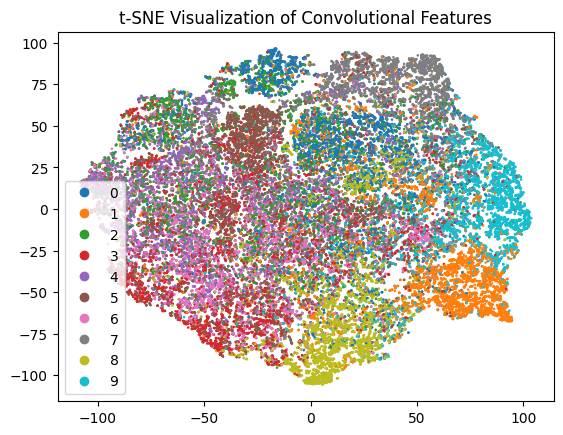

In [42]:
# プロット
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*scatter.legend_elements())
plt.title('t-SNE Visualization of Convolutional Features')
plt.show()

### UMAP

In [43]:
import umap

umap = umap.UMAP(random_state=42)
umap_result = umap.fit_transform(data_for_embedding)
print(umap_result.shape)

/home/gakubu/.local/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(50000, 2)


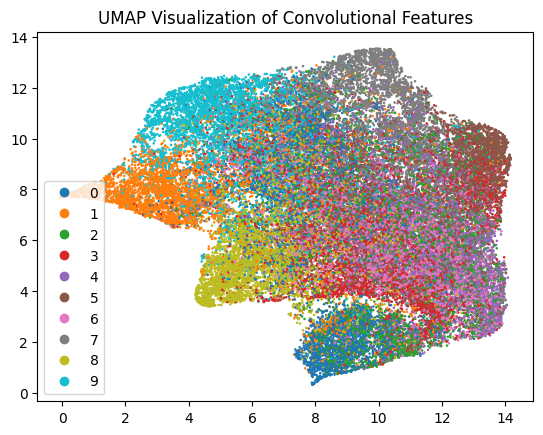

In [44]:
# プロット
scatter = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=y_train.flatten(), cmap="tab10", s=0.7)
plt.legend(*scatter.legend_elements())
plt.title('UMAP Visualization of Convolutional Features')
plt.show()